# Kamień milowy 3
### Zuzanna Glinka
### Karol Degórski
### Adrian Kamiński

#### Streszczenia artykułów z dziedziny

1.   **[Why should I trust you?](http://www.csc.villanova.edu/~beck/csc8570/papers/ribeiro.pdf)** 


"Why Should I Trust You?": Explaining the Predictions of Any Classifier 
￼
W tym artykule autor podejmuje problem wyjaśnień predykcji różnych klasyfikatorów, podkreślając ważność interpretowalności modeli. Pokazuje kilka przykładów wyjaśnień i wpływu konkretnych zmiennych, konfrontując je z intuicją człowieka. Proponuje LIME do wyjaśniania klasyfikacji, pokazuje jej efektywność oraz przewagę nad innymi technikami. Ciekawe były przykłady badań tego jak ludzie ufają algorytmom i co na to wpływa, pokazując, że dzięki wyjaśnieniom człowiek jest w stanie mieć większą kontrolę nad algorytmami i analizą ich poprawności.  
Mimo wielu zalet, tam metoda posiada kilka wad m.in. nie działa za dobrze dla złożonych danych. 

2.   **[Towards Automatic Concept-based Explanations](https://arxiv.org/abs/1902.03129)** 


Artykuł wprowadza nową globalną metodę Automated Concept-based Explanation (ACE), służącą do automatycznego znajdowania wyjaśnień zrozumiałych dla człowieka. Najważniejsze cechy wyjaśnień opartych na konceptach są: 
- istotność - np. pojedynczy piksel ma małe znaczenie, ale już grupa pikseli może wyjaśniać kształt, czy teksturę,
- spójność - elementy tego samego konceptu powinny być podobne do siebie i powinny się różnić od innych konceptów, 
- ważność - koncept jest ważny, gdy jego obecność jest niezbędna do dokonania danej predykcji.
  
Zaletą tej metody jest dostarczanie dobrych wyjaśnień modeli już wcześniej wytrenowanych. Po przeprowadzeniu eksperymentów ankietowani istotnie wskazywali na lepsze wyjaśnienia metody ACE. Niestety metoda ACE może nie poradzić sobie ze złożonymi i abstrakcyjnymi konceptami. Ograniczeniem tej metody jest również możliwość wyjaśnień jedynie danych obrazowych, a nie np. tekstowych.

3. **[Explaining Predictions of Non-Linear Classifiers in NLP](https://arxiv.org/abs/1606.07298)**  


Artykuł przedstawia porównanie LRP (Layer-wise relevance propagation), techniki do wyjaśniania złożonych nie liniowych klasyfikatorów w kontekście zmiennych wejściowych z metodą SA (Sensitivity Analysis). Przedstawone jest rozwiązywanie problemu NLP i jego wyjaśnialności. Mocną stroną LRP jest fakt, że oprócz wskazywania które słowa wpływają pozytywnie na decyję o przypisaniu do konkretnej klasy, zwraca on również słowa które wpływają negatywnie, czego SA nie robi. Co rzeczywiście jest pomocnę, przynajmniej dla ludziego oka, co pokazali na wizualizacji z podkreślonymi słowami (tych wpływających pozytywnie i dla LRP niegatywnie)). Wykonanie PCA pokazało że użycie LRP pozwala lepiej rozróżnić różne kategorie dokumentów.


#### Wczytanie modelu 

In [1]:
import numpy as np
import os
import math
import random
import warnings
import copy
warnings.filterwarnings("ignore")

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = "cuda:0" if torch.cuda.is_available() else 'cpu'

In [3]:
_resnet18 = torchvision.models.resnet18(pretrained=True)

In [4]:
class NetWrapper(torch.nn.Module):
    def __init__(self, model, num_classes):
        super(NetWrapper, self).__init__()
        self.model = model
        self.flatten = nn.Flatten()
        self.linear0 = nn.Linear(1000, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.ReLU = nn.ReLU()
        self.linear = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.model(x)
        x = self.flatten(x)
        x = self.linear0(x)
        x = self.ReLU(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.softmax(x)
        return x

In [5]:
CLASSES = os.listdir('../data/train')
CLASSES.sort()
CLASSES = np.array(CLASSES)
CLASSES

array(['circle', 'none', 'square', 'triangle'], dtype='<U8')

In [ ]:
resnet18 = NetWrapper(_resnet18, CLASSES.size).to(device)

resnet18.load_state_dict(torch.load('../models_18-05/resnet18.pth', map_location=torch.device(device)))
resnet18.eval()
resnet18.to(device)

In [7]:
transformations = torchvision.transforms.Compose([
    # torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_set = torchvision.datasets.ImageFolder("../data/test/", transform = transformations)

# train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)
# test_loader = torch.load('test_loader.pt')

#### Wyjaśnienie klasyfikatora metodami z labolatoriów

In [8]:
# pip install captum
from captum.attr import visualization

def show_attr(attr_map):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True
    )

In [9]:
preprocess = torchvision.transforms.Compose([
   # torchvision.transforms.ToTensor(),
])

In [10]:
from skimage import segmentation

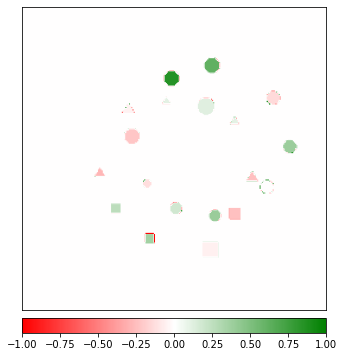

In [13]:
from captum.attr import KernelShap
exp_ks = KernelShap(resnet18)

def mask(i):
    return segmentation.quickshift(
        test_set[i][0].permute(1, 2, 0).double(), 
        kernel_size=45, 
        max_dist=8, 
        ratio=0.7
    )


def attr_ks(i):
    return exp_ks.attribute(
        preprocess(test_set[i][0].unsqueeze(0)), 
        target=test_set[i][1], 
        n_samples=200, 
        feature_mask=torch.as_tensor(mask(i)),
        show_progress=False,
        baselines = torch.ones(3, 256, 256) * 0.5882
    )

show_attr(attr_ks(10)[0])

In [362]:
def explanin(object):
    normalized=visualization._normalize_image_attr(object.permute(1, 2, 0).numpy(), sign='all', outlier_perc=2)
    big=copy.deepcopy(normalized)
    small=copy.deepcopy(normalized)
    big[big<0.65]=0
    small[small>(-0.65)]=0
    normalized=big+small
    fig, ax = plt.subplots(figsize=(10,5))
    colors = np.zeros(normalized.shape + (3,))
    colors[(0.65<normalized)] = (1,0,0) # czerwone
    colors[(0.65>normalized)] = (0.5, 0.5, 0.5) # szare
    colors[(0==normalized)] =  (0, 0, 1) # niebieskie
    ax.matshow(colors, interpolation='nearest')
    plt.show()

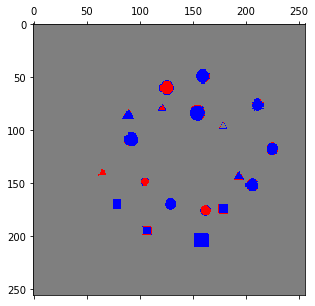

In [363]:
explanin(attr_ks(10)[0])

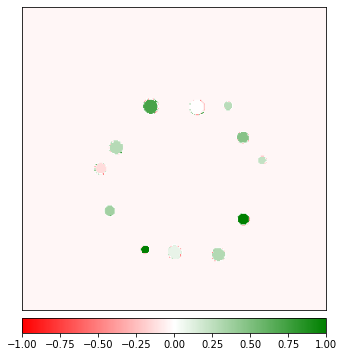

In [364]:
show_attr(attr_ks(4)[0])

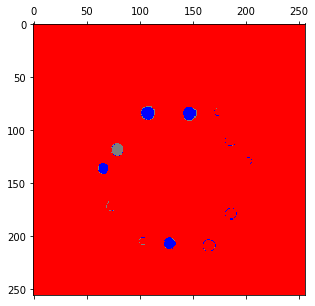

In [365]:
explanin(attr_ks(4)[0])

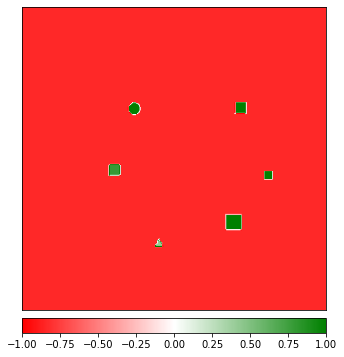

In [370]:
show_attr(attr_ks(1500)[0])

#### Dopracowane podejście do wyjaśnień związanych z postawionym problemem

In [16]:
idx = np.random.randint(0, 4800, size=20)

In [17]:
idx

array([4560, 3491, 4360, 2126, 1450, 2349,  766,  213, 2311,  307, 4503,
       4433, 1441, 3851, 3913, 2757, 1853, 2708, 1161,  890])

In [287]:
# np.save('idx.npy', idx)

In [289]:
importance = []
for _id in idx:
    normalized=visualization._normalize_image_attr(attr_ks(_id)[0].permute(1, 2, 0).numpy(),
                                                   sign='all', outlier_perc=2)
    importance.append(normalized)

In [292]:
# import pickle
# pickle.dump( importance, open( 'importance.p', 'wb' ) )
# pickle.load(open('importance.p', 'rb'))

#### Wczytywanie wszystkich plików csv

In [18]:
import glob

In [295]:
class_encoder = {
    'circle': 0,
    'none': 1,
    'square': 2,
    'triangle': 3
}

csv_list = []
file_names = []
for filename in glob.iglob('../data/details/test/' + '**/*.csv', recursive=True):
    file_names.append(filename.replace('\\','/'))

    class_name = filename.replace('\\','/').split('/')[4]
    csv = pd.read_csv(filename.replace('\\','/'))

    csv['class'] = class_encoder[class_name]

    csv_list.append(csv)

In [296]:
csv_list_ordered = [csv_list[i] for i in np.argsort(file_names)]

In [297]:
def add_columns(df, importance):
    df['isTrue'] = df.label.str.contains('true')
    df['mainShape'] = df.label.str.split().str[-1]

    _min, _max = 5/120, 10/120
    
    df.loc[df['size'] <= _min + (_max-_min)/3, 'size_d'] = 'small'
    df.loc[(df['size'] < _min + (_max-_min)/3 * 2) & (df['size'] > _min + (_max-_min)/3), 'size_d'] = 'medium'
    df.loc[df['size'] >= _min + (_max-_min)/3 * 2, 'size_d'] = 'big'

    # TODO: get more pixels
    df['Importance'] = importance[(df.x*255).round().astype(int).values, (df.y*255).round().astype(int).values]

    return df

In [ ]:
import copy

In [300]:
csv_importance = []
for j, _id in enumerate(idx):
    df = copy.deepcopy(csv_list_ordered[_id])

    df = add_columns(df, importance[j])

    csv_importance.append(df)

In [313]:
class0 = [csv for csv in csv_importance if csv['class'][0] == 0] # 0 - circle

#### Pierwsze próby wyciągnięcia jakichkolwiek informacji

In [371]:
negative_impact_by_shape = {'square': 0, 'triangle': 0, 'circle': 0}
possitive_impact_by_shape = {'square': 0, 'triangle': 0, 'circle': 0}
negative_impact_by_size = {'small': 0, 'medium': 0, 'big': 0}
possitive_impact_by_size = {'small': 0, 'medium': 0, 'big': 0}
for csv in class0:
    for value in csv[csv.Importance==csv.Importance.min()]['shape'].values:
        negative_impact_by_shape[value] += 1 
    for value in csv[csv.Importance==csv.Importance.max()]['shape'].values:
        possitive_impact_by_shape[value] += 1 

    for value in csv[csv.Importance==csv.Importance.min()]['size_d'].values:
        negative_impact_by_size[value] += 1 
    for value in csv[csv.Importance==csv.Importance.max()]['size_d'].values:
        possitive_impact_by_size[value] += 1 

In [372]:
negative_impact_by_shape

{'square': 2, 'triangle': 1, 'circle': 2}

In [373]:
possitive_impact_by_shape

{'square': 13, 'triangle': 8, 'circle': 45}

In [374]:
negative_impact_by_size

{'small': 3, 'medium': 1, 'big': 1}

In [375]:
possitive_impact_by_size

{'small': 24, 'medium': 25, 'big': 17}

In [356]:
class0[0]

,x,y,shape,size,color,label,class,isTrue,mainShape,size_d,Importance
0,0.731162,0.542428,circle,0.075000,blue,true circle,0,True,circle,big,0.030705
1,0.688530,0.775243,circle,0.066667,red,true circle,0,True,circle,medium,0.030705
2,0.342926,0.740277,circle,0.058333,yellow,true circle,0,True,circle,medium,0.030705
3,0.262521,0.568765,circle,0.066667,blue,true circle,0,True,circle,medium,0.030705
4,0.432152,0.323195,circle,0.066667,blue,true circle,0,True,circle,medium,0.030705
5,0.623361,0.359872,circle,0.041667,yellow,true circle,0,True,circle,small,0.030705
6,0.662563,0.392243,triangle,0.075000,yellow,0 false circle,0,False,circle,big,0.030705
7,0.621286,0.524764,circle,0.041667,red,0 false circle,0,False,circle,small,0.030705
8,0.565967,0.646938,square,0.083333,blue,0 false circle,0,False,circle,big,0.030705
9,0.463280,0.694080,square,0.083333,yellow,0 false circle,0,False,circle,big,0.030705


Tabelka zawiera lokalne kompletny opis naszego obrazka wraz z informacjami dostarczonymi przez Shap (odnośnie istotności każdej z figur). Mamy zmienne takie jak:
- shape - kształt figury
- size - rozmiar figury
- color - kolor figury
- label - wzorzec do jakiego należy dana figura
- class - prawdziwa etykieta dla całego obrazka
- isTrue - czy kształt jest częścią figury, która jest prawdziwa (np. koło z kół)
- mainShape - do którego z dużych kształtów należy figura
- size_d - rozmiar figury (zmienna dyskretna przyjmująca wartości: mała, średnia, duża)
- importance - istotność danej figury do dokonania predykcji

#### Nowo wyuczone modele (możliwość porówniania globalnych wyjaśnień różnych modeli, na co który zwraca uwagę)

In [358]:
pd.read_csv('../models_18-05/results_resnet18.csv')

,epoch,loss,accuracy_test,accuracy_train
0,1,0.942898,0.232708,0.234028
1,2,0.888019,0.850208,0.855347
2,3,0.867419,0.836875,0.851528
3,4,0.855443,0.863125,0.887778
4,5,0.849476,0.879375,0.912083
5,6,0.839285,0.868125,0.897708
6,7,0.833280,0.888333,0.919792
7,8,0.828583,0.879792,0.917708
8,9,0.821274,0.892083,0.925069
9,10,0.816618,0.887917,0.928056


In [359]:
pd.read_csv('../models_18-05/results_resnet34.csv')

,epoch,loss,accuracy_test,accuracy_train
0,1,0.944613,0.252292,0.254028
1,2,0.889335,0.836042,0.839028
2,3,0.868677,0.827292,0.835139
3,4,0.855860,0.868542,0.887083
4,5,0.845894,0.782292,0.802431
5,6,0.841134,0.890625,0.912153
6,7,0.834083,0.885000,0.911944
7,8,0.827049,0.871458,0.883750
8,9,0.822237,0.889167,0.914861
9,10,0.816341,0.890833,0.919097


In [360]:
pd.read_csv('../models_18-05/results_vgg11.csv')

,epoch,loss,accuracy_test,accuracy_train
0,1,0.991105,0.222083,0.222431
1,2,0.970295,0.772500,0.768750
2,3,0.938328,0.761458,0.758958
3,4,0.926082,0.850208,0.853472
4,5,0.936328,0.799792,0.810972
5,6,0.951774,0.827500,0.831736
6,7,0.958401,0.754167,0.755139
7,8,0.961301,0.804375,0.815139
8,9,1.003915,0.725417,0.725417
9,10,1.071187,0.804167,0.807431


In [361]:
pd.read_csv('../models_18-05/results_efficientnet_b0.csv')

,epoch,loss,accuracy_test,accuracy_train
0,1,0.997043,0.329583,0.329931
1,2,0.900639,0.835208,0.848056
2,3,0.876647,0.870000,0.890556
3,4,0.866147,0.875625,0.900764
4,5,0.853615,0.871875,0.902431
5,6,0.845394,0.887083,0.919931
6,7,0.842125,0.886667,0.922639
7,8,0.832227,0.889583,0.931250
8,9,0.824493,0.892500,0.932986
9,10,0.820333,0.894792,0.939028


Widzimy, że najsłabiej poradził sobie model vgg11, natomiast najlepsze wyniki osiąga efficientnet.